In [ ]:
import numpy as np


"""
Using....
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
"""

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from google.colab import files
uploaded = files.upload()
df= pd.read_csv('breast_cancer.csv')

Saving breast_cancer.csv to breast_cancer.csv


In [ ]:
#print(df.describe().T)  #Values need to be normalized before fitting. 
#print(df.isnull().sum())
df = df.dropna()

#Rename Dataset to Label to make it easy to understand
#df = df.rename(columns={'diagnosis':'label'})
#print(df.dtypes)

#Understand the data 
#sns.countplot(x="Label", data=df) #M - malignant   B - benign


####### Replace categorical values with numbers########
df['diagnosis'].value_counts()

#Define the dependent variable that needs to be predicted (labels)
y = df["diagnosis"].values
print(y.shape)


(569,)


In [ ]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        # covariance, function needs samples as columns
        cov = np.cov(X.T)

        # eigenvalues, eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # store first n eigenvectors
        self.components = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        X = X - self.mean
        return np.dot(X, self.components.T)

Shape of X: (569, 30)
Shape of transformed X: (569, 2)
(569, 2)


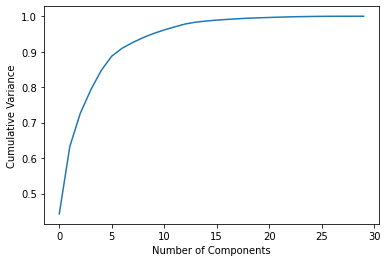

In [ ]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(y) # M=1 and B=0
#################################################################
#Define x and normalize values

#Define the independent variables. Let's also drop Gender, so we can normalize other data
X = df.drop(labels = ["diagnosis", "id"], axis=1) 


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
#print(X.shape)


"""
Generate a Cumulative Variance plot to see the relationship
between the number of principal components useds and the amount of cumulative
variance observed. Think about the cumulative variance as the amount of information contained in
a number of principal components compared to the original dataset.
"""
from sklearn.decomposition import PCA
pca_test = PCA(n_components=30)
pca_test.fit(X)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")

# Project the data onto the 2 primary principal components
pca = PCA(2)
pca.fit(X)
X_projected = pca.transform(X)

print("Shape of X:", X.shape)
print("Shape of transformed X:", X_projected.shape)


X_df = pd.DataFrame(X_projected,columns=['PC1','PC2'])
#X_y_df = df_scores = pd.concat([X_df, Species], axis=1)



print(X_df.shape)



#Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_df, Y, test_size=0.25, random_state=42)

In [ ]:
#Creating a Multilayer Perceptron Model to use to traing our dataset

model = Sequential()
model.add(Dense(16, input_dim=2, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(1)) 
model.add(Activation('sigmoid'))  
model.compile(loss='binary_crossentropy',
              optimizer='adam',             #also try adam
              metrics=['accuracy'])
print(model.summary())

###########################################################

# Fit the model to our dataset


import datetime
start = datetime.datetime.now()
# # fit the model
history = model.fit(X_train, y_train ,verbose=1, epochs=100, batch_size=64,
                     validation_data=(X_test, y_test))

end = datetime.datetime.now()

print("Total execution time is: ", end-start)

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                48        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
7/7 [==============================] - 1s 36ms/step - loss: 0.8584 - accuracy: 0.3615 - val_loss: 0.7184 - val_accuracy: 0.3986
Epoch 2/100
7/7 [============================

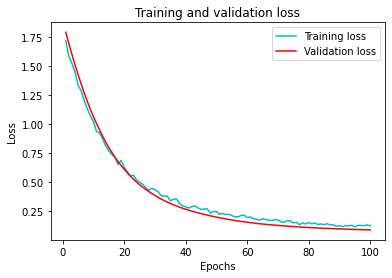

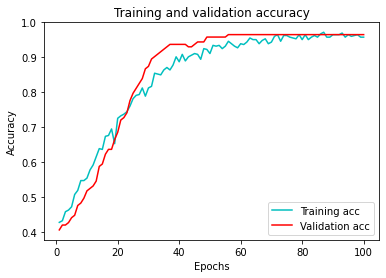

(143,)


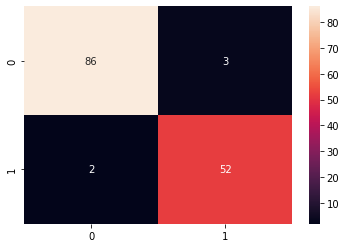

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'c', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'c', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Predict the label for X_test data
y_pred = model.predict(X_test)
print(y_test.shape)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)



